In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
import warnings
warnings.filterwarnings('ignore')

In [2]:
claims_data = pd.read_csv("Fianl_claims_data.csv")

In [3]:
memebrship_data = pd.read_csv("health_insurance_membership_10k_corrected_age.csv")

In [4]:
common_cols = set(memebrship_data.columns).intersection(set(claims_data.columns))
cols_to_add = [col for col in claims_data.columns if col not in common_cols]

merged_df = pd.merge(memebrship_data, claims_data[cols_to_add], left_on="Unique ID",right_on='Claimant Unique ID', how='left')

In [5]:
merged_df.columns

Index(['Industry', 'Client Name', 'Client Identifier',
       'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Status of Member',
       'Gender', 'Status of Registration', 'Unique Member Reference',
       'Unique ID', 'Short Post Code', 'Registration Status',
       'Contract Start Date', 'Contract End Date', 'Original Date of Joining',
       'Scheme Policy Joining Date', 'Lapse Date', 'Year of Birth', 'Age',
       'Claimant Unique ID', 'Claim ID', 'Incurred Date', 'Paid Date',
       'Condition Code', 'Impairment Code', 'Condition Category',
       'Treatment Type', 'Claim Type', 'Ancillary Service Type',
       'Treatment Location', 'Provider Type', 'Admission Date',
       'Discharge Date', 'Calculate Length of Service', 'Claim Amount',
       'Amount Paid'],
      dtype='object')

In [6]:
merged_df.sample(5)

,Industry,Client Name,Client Identifier,Scheme Category/ Section Name,Scheme Category/ Section Name Identifier,Status of Member,Gender,Status of Registration,Unique Member Reference,Unique ID,Short Post Code,Registration Status,Contract Start Date,Contract End Date,Original Date of Joining,Scheme Policy Joining Date,Lapse Date,Year of Birth,Age,Claimant Unique ID,Claim ID,Incurred Date,Paid Date,Condition Code,Impairment Code,Condition Category,Treatment Type,Claim Type,Ancillary Service Type,Treatment Location,Provider Type,Admission Date,Discharge Date,Calculate Length of Service,Claim Amount,Amount Paid
54121,IT,Sage Group,CLI000004,Executive Cover,SCH0002,Dependent,Male,Single Parent Family,EMP00004223,EMP00004223-03,L2,Active,01-11-2019,18-10-2021,12-06-2019,12-11-2019,NaN,1994,31,EMP00004223-03,CLM00090063,19/06/2020,19/07/2020,M51.2,IMP-MSK-956,Musculoskeletal,Surgical,Inpatient,Physiotherapy,England,Hospital,19/06/2020,27/06/2020,8.0,13379.53,11741.22
462,IT,Fujitsu UK,CLI000000,Essential Cover,SCH0008,Dependent,Female,Family,EMP00000022,EMP00000022-05,W1A,Active,04-10-2018,26-07-2021,20-04-2018,27-10-2018,NaN,1944,81,EMP00000022-05,CLM00025930,30/11/2019,28/12/2019,M23.2,IMP-MSK-935,Musculoskeletal,Surgical,Day Case,NaN,England,Hospital,30/11/2019,30/11/2019,1.0,9561.59,8506.30
75075,Pharmaceutical,GlaxoSmithKline (GSK),CLI000020,Enhanced Plan,SCH0004,Dependent,Male,Family,EMP00005990,EMP00005990-02,NE2,Active,20-10-2019,14-08-2022,15-07-2019,17-11-2019,NaN,1974,51,EMP00005990-02,CLM00101954,19/07/2020,30/07/2020,R50.9,IMP-GEN-286,Other,Diagnostic,Day Case,NaN,England,Diagnostic Center,19/07/2020,19/07/2020,1.0,2970.89,2594.39
99233,Pharmaceutical,Sanofi UK,CLI000024,Enhanced Plan,SCH0004,Member,Male,Single,EMP00007879,EMP00007879-01,SW1A,Active,30-08-2017,17-10-2019,25-03-2017,16-09-2017,NaN,1972,53,EMP00007879-01,CLM00116084,21/10/2018,30/11/2018,N83.2,IMP-URO-478,Gynaecology,Surgical,Outpatient,NaN,England,Diagnostic Center,NaN,NaN,0.0,2059.38,1814.82
115411,Pharmaceutical,Pfizer UK,CLI000022,Standard Plan,SCH0006,Dependent,Male,Family,EMP00009250,EMP00009250-05,NE2,Active,09-12-2018,27-08-2021,06-11-2018,20-12-2018,NaN,1985,40,EMP00009250-05,CLM00004686,07/10/2020,26/11/2020,H25.9,IMP-OPH-196,Ophthalmology,Diagnostic,Cash Benefit,Optical Services,Northern Ireland,Clinic,NaN,NaN,0.0,989.68,819.11


In [7]:
merged_df.to_csv("Claims_member_join_fianl_data.csv")

In [1]:
"""
UK PMI Claims Prediction Model - Enhanced Feature Engineering
==============================================================
Advanced handling of high-cardinality categorical features (ICD codes, etc.)
Includes: Target encoding, frequency encoding, clustering, and dimensionality reduction
"""

# ============================================================================
# 1. IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
import lightgbm as lgb

# Explainability
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Category encoders (install: pip install category_encoders)
try:
    import category_encoders as ce
    CATEGORY_ENCODERS_AVAILABLE = True
except ImportError:
    print("Note: category_encoders not available. Using manual encoding.")
    CATEGORY_ENCODERS_AVAILABLE = False

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:


# ============================================================================
# 2. DATA LOADING
# ============================================================================
from io import StringIO
claims_memebr_df = pd.read_csv(("Claims_member_join_fianl_data.csv"), parse_dates=['Incurred Date', 'Paid Date', 
                                                       'Contract Start Date', 'Contract End Date'])
print(f"\nData Shape: {claims_memebr_df.shape}")
print(f"Unique ICD Codes (Condition Code): {claims_memebr_df['Condition Code'].nunique()}")
print(f"Unique Impairment Codes: {claims_memebr_df['Impairment Code'].nunique()}")


Data Shape: (123830, 37)
Unique ICD Codes (Condition Code): 79
Unique Impairment Codes: 11315


In [8]:


# ============================================================================
# 3. HIGH-CARDINALITY CATEGORICAL ENCODING FUNCTIONS
# ============================================================================

class HighCardinalityEncoder:
    """Handle high-cardinality categorical features like ICD codes"""
    
    def __init__(self, min_frequency=10, top_n=50):
        self.min_frequency = min_frequency
        self.top_n = top_n
        self.encoders = {}
        
    def frequency_encoding(self, claims_memebr_df, column):
        """Encode based on frequency of occurrence"""
        freq = claims_memebr_df[column].value_counts()
        return claims_memebr_df[column].map(freq)
    
    def target_encoding(self, claims_memebr_df, column, target, cv_folds=5):
        """
        Target encoding with cross-validation to prevent overfitting
        Uses mean target value for each category
        """
        # Global mean for smoothing
        global_mean = target.mean()
        
        # Create encoding dictionary with smoothing
        encoding_dict = {}
        for cat in claims_memebr_df[column].unique():
            mask = claims_memebr_df[column] == cat
            n = mask.sum()
            
            # Add smoothing: more weight to global mean for rare categories
            smoothing = 1 / (1 + np.exp(-(n - self.min_frequency) / 10))
            cat_mean = target[mask].mean() if n > 0 else global_mean
            
            encoding_dict[cat] = smoothing * cat_mean + (1 - smoothing) * global_mean
        
        return claims_memebr_df[column].map(encoding_dict).fillna(global_mean)
    
    def rare_category_grouping(self, claims_memebr_df, column):
        """Group rare categories into 'Other'"""
        freq = claims_memebr_df[column].value_counts()
        rare_categories = freq[freq < self.min_frequency].index
        
        result = claims_memebr_df[column].copy()
        result[result.isin(rare_categories)] = 'OTHER'
        
        return result
    
    def hierarchical_encoding(self, claims_memebr_df, column):
        """
        Extract hierarchical information from codes
        E.g., ICD M54.5 -> M54 (parent) and M (chapter)
        """
        features = {}
        
        # Extract different levels
        codes = claims_memebr_df[column].astype(str)
        
        # Level 1: First character (chapter)
        features[f'{column}_chapter'] = codes.str[0]
        
        # Level 2: First 3 characters (category)
        features[f'{column}_category'] = codes.str[:3]
        
        # Level 3: Full code with decimals removed
        features[f'{column}_subcategory'] = codes.str.replace('.', '', regex=False)
        
        return pd.DataFrame(features)

def encode_icd_codes(claims_memebr_df, column='Condition Code'):
    """
    Comprehensive ICD code encoding
    Creates multiple feature representations
    """
    features = {}
    
    # 1. Frequency encoding
    features[f'{column}_frequency'] = claims_memebr_df.groupby(column)[column].transform('count')
    
    # 2. Hierarchical features
    codes = claims_memebr_df[column].astype(str)
    features[f'{column}_chapter'] = codes.str[0]  # First letter
    features[f'{column}_category'] = codes.str[:3]  # First 3 chars
    
    # 3. Top N categories, rest as 'Other'
    top_codes = claims_memebr_df[column].value_counts().head(50).index
    features[f'{column}_grouped'] = claims_memebr_df[column].apply(
        lambda x: x if x in top_codes else 'OTHER'
    )
    
    return pd.DataFrame(features)

In [9]:


# ============================================================================
# 4. ADVANCED FEATURE ENGINEERING
# ============================================================================

def engineer_features_advanced(claims_memebr_df, observation_date=None, prediction_period='yearly'):
    """
    Advanced feature engineering with proper categorical handling
    """
    
    if observation_date is None:
        observation_date = claims_memebr_df['Incurred Date'].max()
    
    print(f"\n{'='*60}")
    print(f"ADVANCED FEATURE ENGINEERING")
    print(f"{'='*60}")
    print(f"Observation date: {observation_date}")
    print(f"Prediction period: {prediction_period}")
    
    # Filter data up to observation date
    df_obs = claims_memebr_df[claims_memebr_df['Incurred Date'] <= observation_date].copy()
    
    # Initialize encoder
    hc_encoder = HighCardinalityEncoder(min_frequency=5, top_n=50)
    
    # Member-level aggregation
    member_features = []
    
    for member_id, member_df in df_obs.groupby('Unique ID'):
        features = {'Unique ID': member_id}
        
        # ======================
        # TEMPORAL FEATURES
        # ======================
        contract_start = member_df['Contract Start Date'].min()
        days_since_start = (observation_date - contract_start).days
        
        features['days_since_contract_start'] = days_since_start
        features['months_since_contract_start'] = days_since_start / 30.44
        features['years_since_contract_start'] = days_since_start / 365.25
        
        # Data availability indicator
        features['data_maturity_score'] = min(days_since_start / 365.25, 1.0)
        features['is_new_member'] = 1 if days_since_start < 180 else 0
        features['is_established_member'] = 1 if days_since_start > 365 else 0
        
        # ======================
        # BASIC CLAIMS FEATURES
        # ======================
        features['total_claims'] = len(member_df)
        features['total_claim_amount'] = member_df['Claim Amount'].sum()
        features['total_paid_amount'] = member_df['Amount Paid'].sum()
        features['avg_claim_amount'] = member_df['Claim Amount'].mean()
        features['std_claim_amount'] = member_df['Claim Amount'].std() if len(member_df) > 1 else 0
        features['max_claim_amount'] = member_df['Claim Amount'].max()
        features['min_claim_amount'] = member_df['Claim Amount'].min()
        features['claim_payment_ratio'] = (member_df['Amount Paid'].sum() / 
                                           member_df['Claim Amount'].sum() 
                                           if member_df['Claim Amount'].sum() > 0 else 1.0)
        
        # Claim frequency
        if days_since_start > 0:
            features['claims_per_year'] = (len(member_df) / days_since_start) * 365.25
            features['amount_per_year'] = (member_df['Claim Amount'].sum() / days_since_start) * 365.25
        else:
            features['claims_per_year'] = 0
            features['amount_per_year'] = 0
        
        # Recent activity windows
        for days in [30, 90, 180, 365]:
            recent_date = observation_date - timedelta(days=days)
            recent_claims = member_df[member_df['Incurred Date'] >= recent_date]
            features[f'claims_last_{days}d'] = len(recent_claims)
            features[f'amount_last_{days}d'] = recent_claims['Claim Amount'].sum()
            features[f'avg_amount_last_{days}d'] = recent_claims['Claim Amount'].mean() if len(recent_claims) > 0 else 0
        
        # Time since last claim
        if len(member_df) > 0:
            days_since_last = (observation_date - member_df['Incurred Date'].max()).days
            features['days_since_last_claim'] = days_since_last
            features['has_recent_claim'] = 1 if days_since_last < 90 else 0
            features['has_very_recent_claim'] = 1 if days_since_last < 30 else 0
        else:
            features['days_since_last_claim'] = 9999
            features['has_recent_claim'] = 0
            features['has_very_recent_claim'] = 0
        
        # ======================
        # ICD/CONDITION CODE FEATURES (HIGH-CARDINALITY)
        # ======================
        
        # Unique counts
        features['unique_condition_codes'] = member_df['Condition Code'].nunique()
        features['unique_impairment_codes'] = member_df['Impairment Code'].nunique()
        features['unique_condition_categories'] = member_df['Condition Category'].nunique()
        
        # Most common codes (Top 3)
        condition_counts = member_df['Condition Code'].value_counts()
        for i in range(min(3, len(condition_counts))):
            features[f'top_{i+1}_condition_code'] = condition_counts.index[i]
            features[f'top_{i+1}_condition_frequency'] = condition_counts.values[i]
            features[f'top_{i+1}_condition_pct'] = condition_counts.values[i] / len(member_df)
        
        # ICD Chapter encoding (first letter)
        if len(member_df) > 0:
            icd_chapters = member_df['Condition Code'].astype(str).str[0].value_counts()
            for chapter, count in icd_chapters.items():
                features[f'icd_chapter_{chapter}_count'] = count
                features[f'icd_chapter_{chapter}_pct'] = count / len(member_df)
        
        # Average claim amount by condition
        condition_amounts = member_df.groupby('Condition Code')['Claim Amount'].mean()
        features['avg_amount_per_condition'] = condition_amounts.mean()
        features['max_condition_avg_amount'] = condition_amounts.max() if len(condition_amounts) > 0 else 0
        
        # Condition category features
        if len(member_df) > 0:
            features['primary_condition_category'] = member_df['Condition Category'].mode()[0]
            category_counts = member_df['Condition Category'].value_counts()
            features['condition_category_diversity'] = len(category_counts) / len(member_df)
            
            # Specific condition categories
            for category in member_df['Condition Category'].unique():
                pct = (member_df['Condition Category'] == category).mean()
                features[f'pct_{category.lower().replace(" ", "_")}'] = pct
        
        # ======================
        # IMPAIRMENT CODE FEATURES
        # ======================
        impairment_counts = member_df['Impairment Code'].value_counts()
        if len(impairment_counts) > 0:
            features['most_common_impairment'] = impairment_counts.index[0]
            features['most_common_impairment_pct'] = impairment_counts.values[0] / len(member_df)
        
        # Extract impairment type (from IMP-XXX-NNN format)
        if len(member_df) > 0:
            impairment_types = member_df['Impairment Code'].astype(str).str.split('-').str[1]
            type_counts = impairment_types.value_counts()
            for imp_type, count in type_counts.items():
                features[f'impairment_type_{imp_type}_count'] = count
                features[f'impairment_type_{imp_type}_pct'] = count / len(member_df)
        
        # ======================
        # TREATMENT FEATURES
        # ======================
        features['pct_surgical'] = (member_df['Treatment Type'] == 'Surgical').mean()
        features['pct_diagnostic'] = (member_df['Treatment Type'] == 'Diagnostic').mean()
        features['pct_therapeutic'] = (member_df['Treatment Type'] == 'Therapeutic').mean()
        features['pct_medical'] = (member_df['Treatment Type'] == 'Medical').mean()
        
        features['pct_inpatient'] = (member_df['Claim Type'] == 'Inpatient').mean()
        features['pct_daycase'] = (member_df['Claim Type'] == 'Day Case').mean()
        features['pct_outpatient'] = (member_df['Claim Type'] == 'Outpatient').mean()
        
        # Treatment location diversity
        features['unique_treatment_locations'] = member_df['Treatment Location'].nunique()
        features['most_common_location'] = member_df['Treatment Location'].mode()[0] if len(member_df) > 0 else 'Unknown'
        
        # Provider type features
        features['unique_provider_types'] = member_df['Provider Type'].nunique()
        provider_counts = member_df['Provider Type'].value_counts()
        for provider, count in provider_counts.items():
            features[f'provider_{provider.lower().replace(" ", "_")}_count'] = count
            features[f'provider_{provider.lower().replace(" ", "_")}_pct'] = count / len(member_df)
        
        # Length of service statistics
        features['avg_length_of_service'] = member_df['Calculate Length of Service'].mean()
        features['max_length_of_service'] = member_df['Calculate Length of Service'].max()
        features['total_days_of_service'] = member_df['Calculate Length of Service'].sum()
        
        # Ancillary services
        features['has_physiotherapy'] = 1 if (member_df['Ancillary Service Type'] == 'Physiotherapy').any() else 0
        features['pct_with_ancillary'] = member_df['Ancillary Service Type'].notna().mean()
        
        # ======================
        # DEMOGRAPHIC FEATURES
        # ======================
        features['age'] = member_df['Age'].iloc[-1]
        features['gender'] = member_df['Gender'].iloc[-1]
        features['year_of_birth'] = member_df['Year of Birth'].iloc[-1]
        
        # Age groups
        age = features['age']
        features['age_group'] = '60+' if age >= 60 else ('45-59' if age >= 45 else ('30-44' if age >= 30 else '18-29'))
        features['is_senior'] = 1 if age >= 60 else 0
        
        # ======================
        # POLICY/CLIENT FEATURES
        # ======================
        features['industry'] = member_df['Industry'].iloc[-1]
        features['client_name'] = member_df['Client Name'].iloc[-1]
        features['client_identifier'] = member_df['Client Identifier'].iloc[-1]
        features['scheme_category'] = member_df['Scheme Category/ Section Name'].iloc[-1]
        
        # Postcode (grouped)
        features['postcode_area'] = member_df['Short Post Code'].iloc[-1][:2] if pd.notna(member_df['Short Post Code'].iloc[-1]) else 'UNK'
        
        # ======================
        # TEMPORAL PATTERNS
        # ======================
        if len(member_df) > 1:
            member_df_sorted = member_df.sort_values('Incurred Date')
            
            # Claim intervals
            claim_dates = member_df_sorted['Incurred Date']
            intervals = claim_dates.diff().dt.days.dropna()
            if len(intervals) > 0:
                features['avg_days_between_claims'] = intervals.mean()
                features['std_days_between_claims'] = intervals.std()
                features['min_days_between_claims'] = intervals.min()
            
            # Trend analysis
            if len(member_df_sorted) >= 4:
                quarter_size = len(member_df_sorted) // 4
                recent_quarter = member_df_sorted.iloc[-quarter_size:]
                earlier_quarter = member_df_sorted.iloc[:quarter_size]
                
                features['claim_amount_trend'] = (recent_quarter['Claim Amount'].mean() / 
                                                 earlier_quarter['Claim Amount'].mean() 
                                                 if earlier_quarter['Claim Amount'].mean() > 0 else 1.0)
                features['claim_frequency_trend'] = len(recent_quarter) / len(earlier_quarter)
            else:
                features['claim_amount_trend'] = 1.0
                features['claim_frequency_trend'] = 1.0
            
            # Seasonality (month of year)
            month_counts = member_df['Incurred Date'].dt.month.value_counts()
            features['most_common_claim_month'] = month_counts.index[0]
            features['claim_month_diversity'] = len(month_counts) / 12
        
        # ======================
        # COMPLEXITY INDICATORS
        # ======================
        features['claim_complexity_score'] = (
            features['unique_condition_codes'] * 0.3 +
            features['unique_provider_types'] * 0.2 +
            features['avg_length_of_service'] * 0.2 +
            (1 if features['pct_inpatient'] > 0 else 0) * 0.3
        )
        
        # High-cost indicator
        features['has_high_cost_claim'] = 1 if features['max_claim_amount'] > 5000 else 0
        features['pct_high_cost_claims'] = (member_df['Claim Amount'] > 5000).mean()
        
        member_features.append(features)
    
    features_df = pd.DataFrame(member_features)
    
    print(f"\n✓ Created {len(features_df.columns)} features for {len(features_df)} members")

    
    return features_df

# Create advanced features
features_df = engineer_features_advanced(claims_memebr_df, observation_date=pd.Timestamp('2023-01-01'))


ADVANCED FEATURE ENGINEERING
Observation date: 2023-01-01 00:00:00
Prediction period: yearly

✓ Created 174 features for 12678 members


In [10]:


# ============================================================================
# 5. CATEGORICAL FEATURE ENCODING FOR MODELING
# ============================================================================

def encode_categorical_features(claims_memebr_df, target=None, method='mixed'):
    """
    Encode categorical features using multiple strategies
    
    Parameters:
    -----------
    method: 'label', 'target', 'mixed'
    """
    
    print(f"\n{'='*60}")
    print(f"ENCODING CATEGORICAL FEATURES")
    print(f"{'='*60}")
    
    df_encoded = claims_memebr_df.copy()
    encoding_info = {}
    
    # Identify categorical columns
    categorical_cols = claims_memebr_df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col != 'Unique ID']
    
    print(f"Found {len(categorical_cols)} categorical columns")
    
    # High-cardinality columns (>50 unique values)
    high_card_cols = [col for col in categorical_cols 
                      if claims_memebr_df[col].nunique() > 50]
    
    # Low-cardinality columns (<=50 unique values)
    low_card_cols = [col for col in categorical_cols 
                     if claims_memebr_df[col].nunique() <= 50]
    
    print(f"  - High-cardinality (>50 unique): {len(high_card_cols)}")
    print(f"  - Low-cardinality (<=50 unique): {len(low_card_cols)}")
    
    # ======================
    # HANDLE HIGH-CARDINALITY
    # ======================
    for col in high_card_cols:
        print(f"\nProcessing high-cardinality: {col} ({claims_memebr_df[col].nunique()} unique values)")
        
        # Strategy 1: Frequency encoding
        freq_map = claims_memebr_df[col].value_counts()
        df_encoded[f'{col}_frequency'] = claims_memebr_df[col].map(freq_map)
        
        # Strategy 2: Top N + Other
        top_n = 30
        top_categories = claims_memebr_df[col].value_counts().head(top_n).index
        df_encoded[f'{col}_grouped'] = claims_memebr_df[col].apply(
            lambda x: x if x in top_categories else 'OTHER'
        )
        
        # Strategy 3: Target encoding (if target provided)
        if target is not None:
            global_mean = target.mean()
            target_map = {}
            for cat in claims_memebr_df[col].unique():
                mask = claims_memebr_df[col] == cat
                n = mask.sum()
                # Smoothing
                smoothing = 1 / (1 + np.exp(-(n - 5) / 5))
                cat_mean = target[mask].mean() if n > 0 else global_mean
                target_map[cat] = smoothing * cat_mean + (1 - smoothing) * global_mean
            
            df_encoded[f'{col}_target_encoded'] = claims_memebr_df[col].map(target_map).fillna(global_mean)
        
        # Drop original column
        df_encoded = df_encoded.drop(columns=[col])
        encoding_info[col] = 'high_card_multi_strategy'
    
    # ======================
    # HANDLE LOW-CARDINALITY
    # ======================
    label_encoders = {}
    for col in low_card_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        encoding_info[col] = 'label_encoded'
    
    # Also encode the _grouped columns created earlier
    grouped_cols = [col for col in df_encoded.columns if '_grouped' in col and df_encoded[col].dtype == 'object']
    for col in grouped_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        encoding_info[col] = 'label_encoded_grouped'
    
    print(f"\n✓ Encoding complete. Shape: {df_encoded.shape}")
    print(f"✓ Encoded {len(label_encoders)} columns total")
    
    # Final validation - check for any remaining object columns
    remaining_objects = df_encoded.select_dtypes(include=['object']).columns.tolist()
    remaining_objects = [col for col in remaining_objects if col not in ['Unique ID']]
    
    if remaining_objects:
        print(f"\n Warning: {len(remaining_objects)} object columns remain. Encoding them...")
        for col in remaining_objects:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le
            print(f"  Encoded remaining: {col}")
    
    return df_encoded, label_encoders, encoding_info

In [11]:

# ============================================================================
# 6. TARGET CREATION AND DATA PREP
# ============================================================================

def create_targets(claims_memebr_df, features_df, observation_date, prediction_period='yearly'):
    """Create target variables"""
    
    period_days = {'yearly': 365, 'half_yearly': 182, 'quarterly': 91}
    days = period_days[prediction_period]
    target_start = observation_date + timedelta(days=1)
    target_end = observation_date + timedelta(days=days)
    
    print(f"\nTarget period: {target_start} to {target_end}")
    
    df_target = claims_memebr_df[(claims_memebr_df['Incurred Date'] > target_start) & 
                   (claims_memebr_df['Incurred Date'] <= target_end)]
    
    target_agg = df_target.groupby('Unique ID').agg({
        'Claim ID': 'count',
        'Claim Amount': 'sum',
        'Amount Paid': 'sum'
    }).reset_index()
    
    target_agg.columns = ['Unique ID', 'target_claim_count', 
                         'target_claim_amount', 'target_paid_amount']
    
    final_df = features_df.merge(target_agg, on='Unique ID', how='left')
    final_df['target_claim_count'] = final_df['target_claim_count'].fillna(0)
    final_df['target_claim_amount'] = final_df['target_claim_amount'].fillna(0)
    final_df['target_paid_amount'] = final_df['target_paid_amount'].fillna(0)
    
    print(f"Members with claims: {(final_df['target_claim_count'] > 0).sum()}")
    
    return final_df

final_df = create_targets(claims_memebr_df, features_df, 
                          observation_date=pd.Timestamp('2023-01-01'),
                          prediction_period='yearly')

# Encode features with target encoding
final_df_encoded, label_encoders, encoding_info = encode_categorical_features(
    final_df.drop(columns=['target_claim_count', 'target_claim_amount', 'target_paid_amount']),
    target=final_df['target_claim_amount'],
    method='mixed'
)

# Add targets back
for col in ['target_claim_count', 'target_claim_amount', 'target_paid_amount']:
    final_df_encoded[col] = final_df[col]


Target period: 2023-01-02 00:00:00 to 2024-01-01 00:00:00
Members with claims: 1976

ENCODING CATEGORICAL FEATURES
Found 13 categorical columns
  - High-cardinality (>50 unique): 4
  - Low-cardinality (<=50 unique): 9

Processing high-cardinality: top_1_condition_code (79 unique values)

Processing high-cardinality: top_2_condition_code (79 unique values)

Processing high-cardinality: top_3_condition_code (76 unique values)

Processing high-cardinality: most_common_impairment (6420 unique values)

✓ Encoding complete. Shape: (12678, 182)
✓ Encoded 13 columns total


In [12]:
final_df_encoded.sample(5)

,Unique ID,days_since_contract_start,months_since_contract_start,years_since_contract_start,data_maturity_score,is_new_member,is_established_member,total_claims,total_claim_amount,total_paid_amount,avg_claim_amount,std_claim_amount,max_claim_amount,min_claim_amount,claim_payment_ratio,claims_per_year,amount_per_year,claims_last_30d,amount_last_30d,avg_amount_last_30d,claims_last_90d,amount_last_90d,avg_amount_last_90d,claims_last_180d,amount_last_180d,avg_amount_last_180d,claims_last_365d,amount_last_365d,avg_amount_last_365d,days_since_last_claim,has_recent_claim,has_very_recent_claim,unique_condition_codes,unique_impairment_codes,unique_condition_categories,top_1_condition_frequency,top_1_condition_pct,top_2_condition_frequency,top_2_condition_pct,top_3_condition_frequency,top_3_condition_pct,icd_chapter_M_count,icd_chapter_M_pct,avg_amount_per_condition,max_condition_avg_amount,primary_condition_category,condition_category_diversity,pct_musculoskeletal,most_common_impairment_pct,impairment_type_MSK_count,impairment_type_MSK_pct,pct_surgical,pct_diagnostic,pct_therapeutic,pct_medical,pct_inpatient,pct_daycase,pct_outpatient,unique_treatment_locations,most_common_location,unique_provider_types,provider_hospital_count,provider_hospital_pct,provider_clinic_count,provider_clinic_pct,avg_length_of_service,max_length_of_service,total_days_of_service,has_physiotherapy,pct_with_ancillary,age,gender,year_of_birth,age_group,is_senior,industry,client_name,client_identifier,scheme_category,postcode_area,avg_days_between_claims,std_days_between_claims,min_days_between_claims,claim_amount_trend,claim_frequency_trend,most_common_claim_month,claim_month_diversity,claim_complexity_score,has_high_cost_claim,pct_high_cost_claims,provider_rehab_center_count,provider_rehab_center_pct,provider_diagnostic_center_count,provider_diagnostic_center_pct,icd_chapter_J_count,icd_chapter_J_pct,pct_respiratory,impairment_type_RSP_count,impairment_type_RSP_pct,icd_chapter_R_count,icd_chapter_R_pct,pct_other,impairment_type_GEN_count,impairment_type_GEN_pct,icd_chapter_N_count,icd_chapter_N_pct,pct_gynaecology,impairment_type_URO_count,impairment_type_URO_pct,icd_chapter_C_count,icd_chapter_C_pct,pct_oncology,impairment_type_ONC_count,impairment_type_ONC_pct,icd_chapter_H_count,icd_chapter_H_pct,pct_ophthalmology,impairment_type_OPH_count,impairment_type_OPH_pct,icd_chapter_T_count,icd_chapter_T_pct,icd_chapter_I_count,icd_chapter_I_pct,pct_cardiovascular,impairment_type_CVD_count,impairment_type_CVD_pct,icd_chapter_G_count,icd_chapter_G_pct,pct_neurology,impairment_type_NEU_count,impairment_type_NEU_pct,pct_urology,icd_chapter_F_count,icd_chapter_F_pct,pct_mental_health,impairment_type_MEN_count,impairment_type_MEN_pct,icd_chapter_K_count,icd_chapter_K_pct,pct_digestive,impairment_type_DIG_count,impairment_type_DIG_pct,pct_ent,icd_chapter_L_count,icd_chapter_L_pct,pct_dermatology,impairment_type_DER_count,impairment_type_DER_pct,icd_chapter_E_count,icd_chapter_E_pct,pct_endocrine,impairment_type_END_count,impairment_type_END_pct,pct_rheumatology,icd_chapter_S_count,icd_chapter_S_pct,pct_orthopaedics,impairment_type_ORT_count,impairment_type_ORT_pct,icd_chapter_O_count,icd_chapter_O_pct,pct_maternity,impairment_type_MAT_count,impairment_type_MAT_pct,icd_chapter_D_count,icd_chapter_D_pct,pct_haematology,impairment_type_HAE_count,impairment_type_HAE_pct,pct_gastroenterology,top_1_condition_code_frequency,top_1_condition_code_grouped,top_1_condition_code_target_encoded,top_2_condition_code_frequency,top_2_condition_code_grouped,top_2_condition_code_target_encoded,top_3_condition_code_frequency,top_3_condition_code_grouped,top_3_condition_code_target_encoded,most_common_impairment_frequency,most_common_impairment_grouped,most_common_impairment_target_encoded,target_claim_count,target_claim_amount,target_paid_amount
2059,EMP00001611-01,613,20.137976,1.678303,1.0,0,1,3,11208.46,10580.22,3736.153333,2784.490984,6629.58,1075.17,0.943949,1.787520,6678.450269,0,0.0,0.

In [13]:
final_df_encoded.columns

Index(['Unique ID', 'days_since_contract_start', 'months_since_contract_start',
       'years_since_contract_start', 'data_maturity_score', 'is_new_member',
       'is_established_member', 'total_claims', 'total_claim_amount',
       'total_paid_amount',
       ...
       'top_2_condition_code_target_encoded', 'top_3_condition_code_frequency',
       'top_3_condition_code_grouped', 'top_3_condition_code_target_encoded',
       'most_common_impairment_frequency', 'most_common_impairment_grouped',
       'most_common_impairment_target_encoded', 'target_claim_count',
       'target_claim_amount', 'target_paid_amount'],
      dtype='object', length=185)

In [14]:
# ============================================================================
# 7. PREPARE FOR MODELING
# ============================================================================

target_cols = ['target_claim_count', 'target_claim_amount', 'target_paid_amount']
id_cols = ['Unique ID']

feature_cols = [col for col in final_df_encoded.columns 
               if col not in target_cols + id_cols]

X = final_df_encoded[feature_cols]
y_count = final_df_encoded['target_claim_count']
y_amount = final_df_encoded['target_claim_amount']

# CRITICAL: Ensure all features are numeric
print(f"\n{'='*60}")
print(f"VALIDATING DATA TYPES")
print(f"{'='*60}")

# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f" Found {len(non_numeric_cols)} non-numeric columns. Encoding them...")
    print(f"Non-numeric columns: {non_numeric_cols[:10]}")
    
    # Encode remaining categorical columns
    for col in non_numeric_cols:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            print(f"  Encoded: {col}")

# Fill any NaN values
if X.isnull().any().any():
    print(f"\n Found NaN values. Filling with 0...")
    X = X.fillna(0)

# Verify all columns are numeric
print(f"\n✓ All features are now numeric: {X.select_dtypes(include=[np.number]).shape[1]} columns")

print(f"\n{'='*60}")
print(f"FINAL DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total features: {X.shape[1]}")
print(f"Total samples: {X.shape[0]}")
print(f"Target - Claim count mean: {y_count.mean():.2f}")
print(f"Target - Claim amount mean: £{y_amount.mean():,.2f}")

# Display feature types
print(f"\nFeature data types:")
print(X.dtypes.value_counts())


VALIDATING DATA TYPES

 Found NaN values. Filling with 0...

✓ All features are now numeric: 181 columns

FINAL DATASET SUMMARY
Total features: 181
Total samples: 12678
Target - Claim count mean: 0.74
Target - Claim amount mean: £9,343.52

Feature data types:
float64    144
int64       37
Name: count, dtype: int64


In [15]:
# ============================================================================
# 8. MODEL TRAINING (SAME AS BEFORE)
# ============================================================================

def train_models(X, y, task_name='claim_count'):
    """Train multiple models"""
    
    print(f"\n{'='*60}")
    print(f"Training models for: {task_name}")
    print(f"{'='*60}")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            num_leaves=31,
            min_child_samples=20,
            random_state=42,
            verbose=-1
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        y_pred = np.maximum(y_pred, 0)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")
        
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'actuals': y_test
        }
    
    best_model_name = min(results.keys(), key=lambda k: results[k]['mae'])
    print(f"\n✓ Best model: {best_model_name}")
    
    return results[best_model_name]['model'], scaler, results, X_test_scaled, y_test

# Train models
model_count, scaler_count, results_count, X_test_scaled, y_test_count = train_models(
    X, y_count, 'Claim Count'
)

model_amount, scaler_amount, results_amount, _, y_test_amount = train_models(
    X, y_amount, 'Claim Amount'
)



Training models for: Claim Count

Training LightGBM...
  MAE: 0.3005
  RMSE: 0.9083
  R²: 0.8912

Training Random Forest...
  MAE: 0.2990
  RMSE: 0.9156
  R²: 0.8894

✓ Best model: Random Forest

Training models for: Claim Amount

Training LightGBM...
  MAE: 2792.8245
  RMSE: 18249.2389
  R²: 0.9025

Training Random Forest...
  MAE: 2666.0374
  RMSE: 18221.9364
  R²: 0.9028

✓ Best model: Random Forest



Top 20 Most Important Features:
                              feature  importance
                     claims_last_180d    0.543407
most_common_impairment_target_encoded    0.222154
                      claims_last_90d    0.029947
                      claims_per_year    0.022458
           years_since_contract_start    0.016600
          months_since_contract_start    0.014538
            days_since_contract_start    0.013978
     most_common_impairment_frequency    0.012507
                      amount_last_90d    0.005403
              std_days_between_claims    0.004640
                days_since_last_claim    0.004475
              avg_days_between_claims    0.004436
                        year_of_birth    0.004023
                                  age    0.003883
                    total_paid_amount    0.003574
             max_condition_avg_amount    0.003408
         condition_category_diversity    0.003154
                   total_claim_amount    0.003023
                 

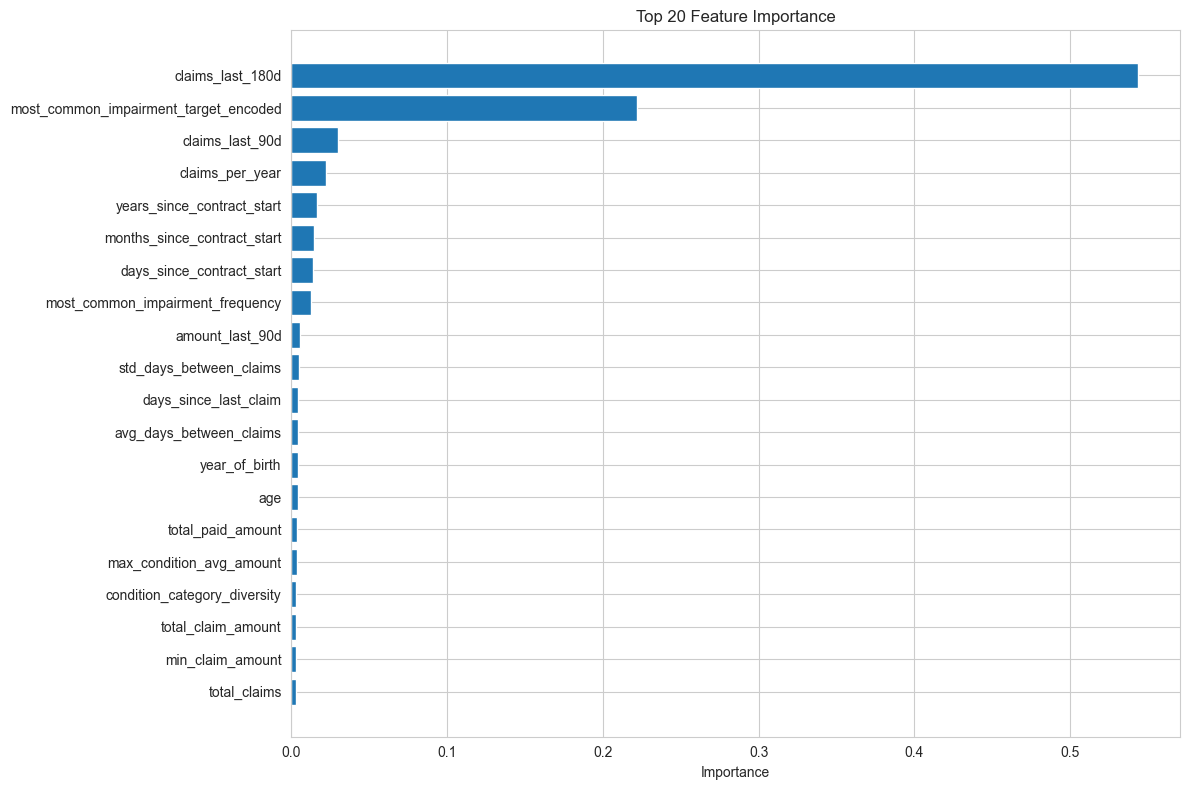


Top 20 Most Important Features:
                              feature  importance
most_common_impairment_target_encoded    0.550275
                     amount_last_180d    0.223801
                      amount_last_90d    0.121274
                     claims_last_180d    0.009404
                      claims_last_90d    0.007752
          months_since_contract_start    0.007352
     most_common_impairment_frequency    0.007220
                     amount_last_365d    0.006991
           years_since_contract_start    0.006090
                     claims_last_365d    0.005884
                days_since_last_claim    0.005265
                  avg_amount_last_90d    0.003161
       provider_diagnostic_center_pct    0.003106
            days_since_contract_start    0.002249
                     std_claim_amount    0.002029
                 avg_amount_last_180d    0.001927
            top_1_condition_frequency    0.001921
              provider_hospital_count    0.001581
                 

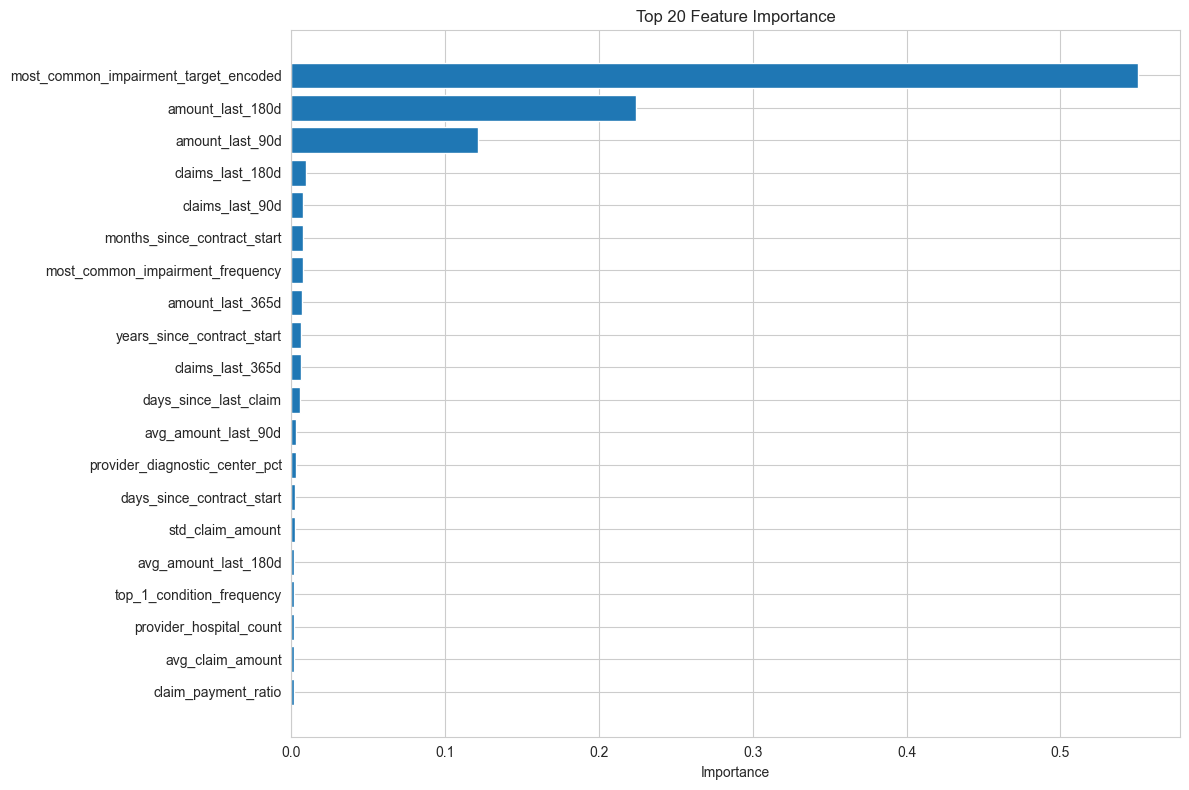

In [16]:
# ============================================================================
# 9. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

def analyze_feature_importance(model, feature_names, top_n=20):
    """Analyze and visualize feature importance"""
    
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        return None
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop {top_n} Most Important Features:")
    print(feature_importance_df.head(top_n).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Analyze importance
fi_count = analyze_feature_importance(model_count, feature_cols, top_n=20)
fi_amount = analyze_feature_importance(model_amount, feature_cols, top_n=20)


Generating SHAP explanations for Claim Count...


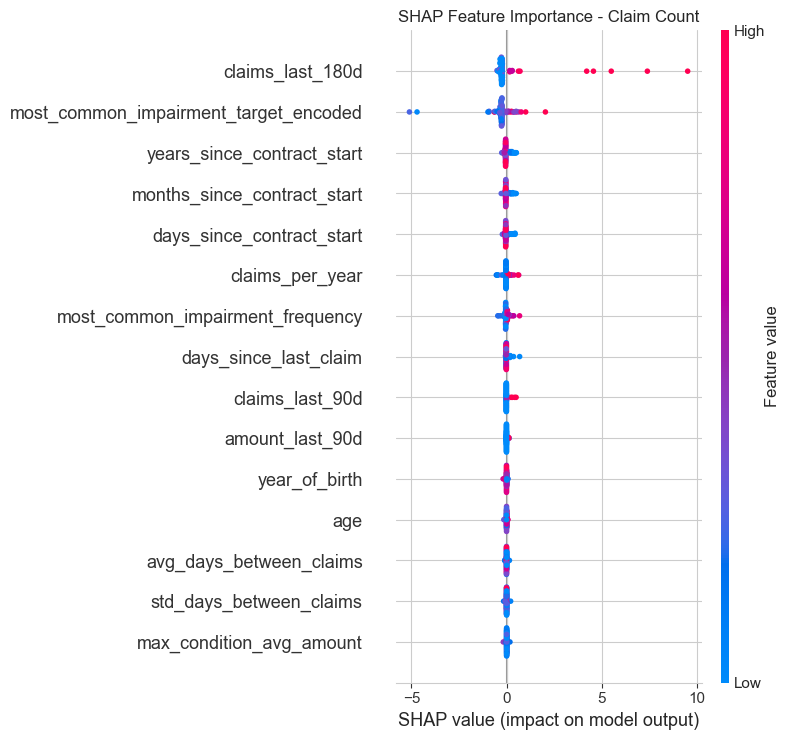


Top 10 SHAP Features for Claim Count:
                              feature  shap_importance
                     claims_last_180d         0.573875
most_common_impairment_target_encoded         0.429515
           years_since_contract_start         0.108544
          months_since_contract_start         0.098501
            days_since_contract_start         0.095357
                      claims_per_year         0.084969
     most_common_impairment_frequency         0.071677
                days_since_last_claim         0.049068
                      claims_last_90d         0.027192
                      amount_last_90d         0.017595

Generating SHAP explanations for Claim Amount...


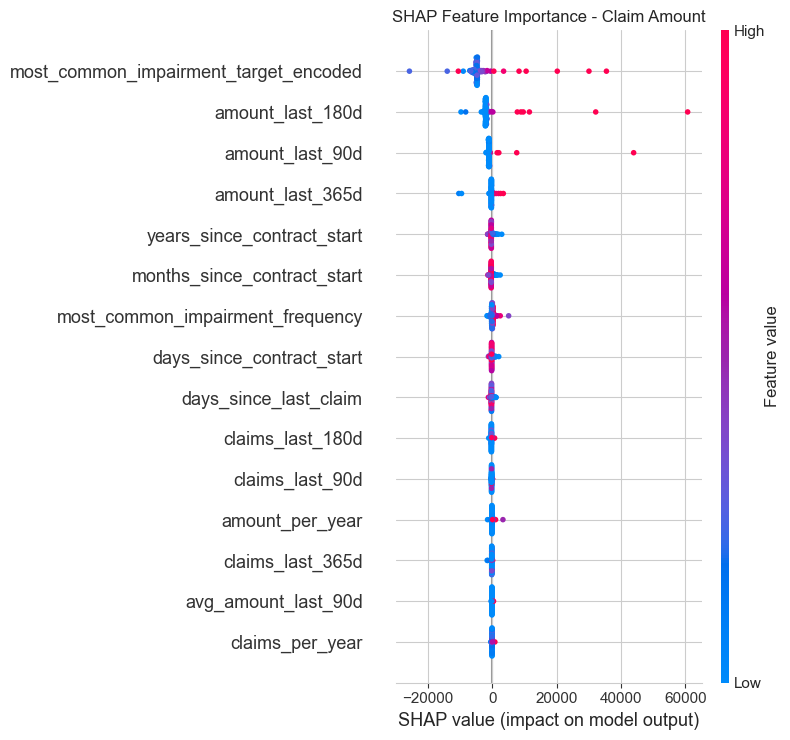


Top 10 SHAP Features for Claim Amount:
                              feature  shap_importance
most_common_impairment_target_encoded      5792.817255
                     amount_last_180d      3299.920801
                      amount_last_90d      1524.020744
                     amount_last_365d       528.674096
           years_since_contract_start       439.689407
          months_since_contract_start       421.168570
     most_common_impairment_frequency       389.976476
            days_since_contract_start       307.309770
                days_since_last_claim       291.235111
                     claims_last_180d       237.032424


In [17]:
# ============================================================================
# 10. MODEL EXPLAINABILITY (SHAP)
# ============================================================================

def explain_model_shap(model, X_test, feature_names, task_name='Model', max_display=15):
    """Generate SHAP explanations"""
    
    print(f"\nGenerating SHAP explanations for {task_name}...")
    
    # Sample for faster computation
    sample_size = min(100, len(X_test))
    X_sample = X_test[:sample_size]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                     show=False, max_display=max_display)
    plt.title(f'SHAP Feature Importance - {task_name}')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('shap_importance', ascending=False)
    
    print(f"\nTop 10 SHAP Features for {task_name}:")
    print(shap_importance.head(10).to_string(index=False))
    
    return explainer, shap_values, shap_importance

# SHAP explanations
explainer_count, shap_values_count, shap_fi_count = explain_model_shap(
    model_count, X_test_scaled, feature_cols, 'Claim Count'
)

explainer_amount, shap_values_amount, shap_fi_amount = explain_model_shap(
    model_amount, X_test_scaled, feature_cols, 'Claim Amount'
)

In [18]:
# ============================================================================
# 11. PREDICTION FUNCTION
# ============================================================================

def predict_claims(member_features_df, model_count, model_amount, 
                  scaler_count, scaler_amount, label_encoders, 
                  encoding_info, feature_cols):
    """
    Make predictions for new members
    """
    
    print(f"\n{'='*60}")
    print(f"MAKING PREDICTIONS")
    print(f"{'='*60}")
    
    # Encode categorical features the same way
    df_encoded, _, _ = encode_categorical_features(
        member_features_df,
        target=None,
        method='mixed'
    )
    
    # Ensure all feature columns present
    missing_cols = set(feature_cols) - set(df_encoded.columns)
    for col in missing_cols:
        df_encoded[col] = 0
    
    X_pred = df_encoded[feature_cols]
    
    # Scale
    X_pred_scaled_count = scaler_count.transform(X_pred)
    X_pred_scaled_amount = scaler_amount.transform(X_pred)
    
    # Predict
    pred_count = model_count.predict(X_pred_scaled_count)
    pred_amount = model_amount.predict(X_pred_scaled_amount)
    
    # Ensure non-negative
    pred_count = np.maximum(pred_count, 0)
    pred_amount = np.maximum(pred_amount, 0)
    
    # Create results
    results = pd.DataFrame({
        'Unique ID': member_features_df['Unique ID'],
        'predicted_claim_count': pred_count,
        'predicted_claim_amount': pred_amount,
        'predicted_avg_claim_amount': pred_amount / np.maximum(pred_count, 0.01),
        'data_maturity_score': member_features_df['data_maturity_score'],
        'is_new_member': member_features_df['is_new_member'],
        'total_historical_claims': member_features_df['total_claims'],
        'total_historical_amount': member_features_df['total_claim_amount'],
        'confidence_level': member_features_df['data_maturity_score'].apply(
            lambda x: 'High' if x > 0.75 else ('Medium' if x > 0.35 else 'Low')
        )
    })
    
    print(f"\n✓ Predictions generated for {len(results)} members")
    print(f"\nPrediction Summary:")
    print(f"  Total predicted claims: {results['predicted_claim_count'].sum():.0f}")
    print(f"  Total predicted amount: £{results['predicted_claim_amount'].sum():,.2f}")
    print(f"  Average per member: £{results['predicted_claim_amount'].mean():,.2f}")
    print(f"  Median per member: £{results['predicted_claim_amount'].median():,.2f}")
    
    print(f"\nConfidence Distribution:")
    print(results['confidence_level'].value_counts())
    
    print(f"\nNew vs Established Members:")
    print(results.groupby('is_new_member').agg({
        'predicted_claim_count': 'mean',
        'predicted_claim_amount': 'mean'
    }).round(2))
    
    return results

# Make predictions
predictions = predict_claims(
    features_df, model_count, model_amount,
    scaler_count, scaler_amount, label_encoders,
    encoding_info, feature_cols
)

print("\nSample Predictions:")
print(predictions.head(10).to_string(index=False))


MAKING PREDICTIONS

ENCODING CATEGORICAL FEATURES
Found 13 categorical columns
  - High-cardinality (>50 unique): 4
  - Low-cardinality (<=50 unique): 9

Processing high-cardinality: top_1_condition_code (79 unique values)

Processing high-cardinality: top_2_condition_code (79 unique values)

Processing high-cardinality: top_3_condition_code (76 unique values)

Processing high-cardinality: most_common_impairment (6420 unique values)

✓ Encoding complete. Shape: (12678, 178)
✓ Encoded 13 columns total

✓ Predictions generated for 12678 members

Prediction Summary:
  Total predicted claims: 1508
  Total predicted amount: £6,437,129.84
  Average per member: £507.74
  Median per member: £0.62

Confidence Distribution:
confidence_level
High      12529
Medium      149
Name: count, dtype: int64

New vs Established Members:
               predicted_claim_count  predicted_claim_amount
is_new_member                                               
0                               0.12             

In [42]:
predictions.sample(5)

,Unique ID,predicted_claim_count,predicted_claim_amount,predicted_avg_claim_amount,data_maturity_score,is_new_member,total_historical_claims,total_historical_amount,confidence_level
6845,EMP00005373-02,0.003712,0.615094,61.509431,1.0,0,8,110134.47,High
392,EMP00000311-05,0.000000,1.508713,150.871345,1.0,0,2,1839.88,High
5045,EMP00003960-02,0.044740,102.006252,2279.982817,1.0,0,1,3446.75,High
8660,EMP00006827-01,0.000000,0.862555,86.255518,1.0,0,3,1325.60,High
3931,EMP00003068-04,0.480197,247.486047,515.384923,1.0,0,12,12885.12,High



CATEGORICAL FEATURE IMPACT ANALYSIS

Predictions by Primary Condition Category:
                           predicted_claim_count             predicted_claim_amount         
                                            mean   std count                   mean      std
primary_condition_category                                                                  
Cardiovascular                              0.12  0.25   950                1416.23  4224.29
Dermatology                                 0.04  0.13   295                  51.23   116.98
Digestive                                   0.07  0.19  1070                 137.40   426.58
ENT                                         0.05  0.10   341                  75.83   174.49
Endocrine                                   0.16  0.32   253                 519.96  1074.49
Gastroenterology                            0.23  0.37    11                 973.81  2005.76
Gynaecology                                 0.09  0.25   906                 179.1

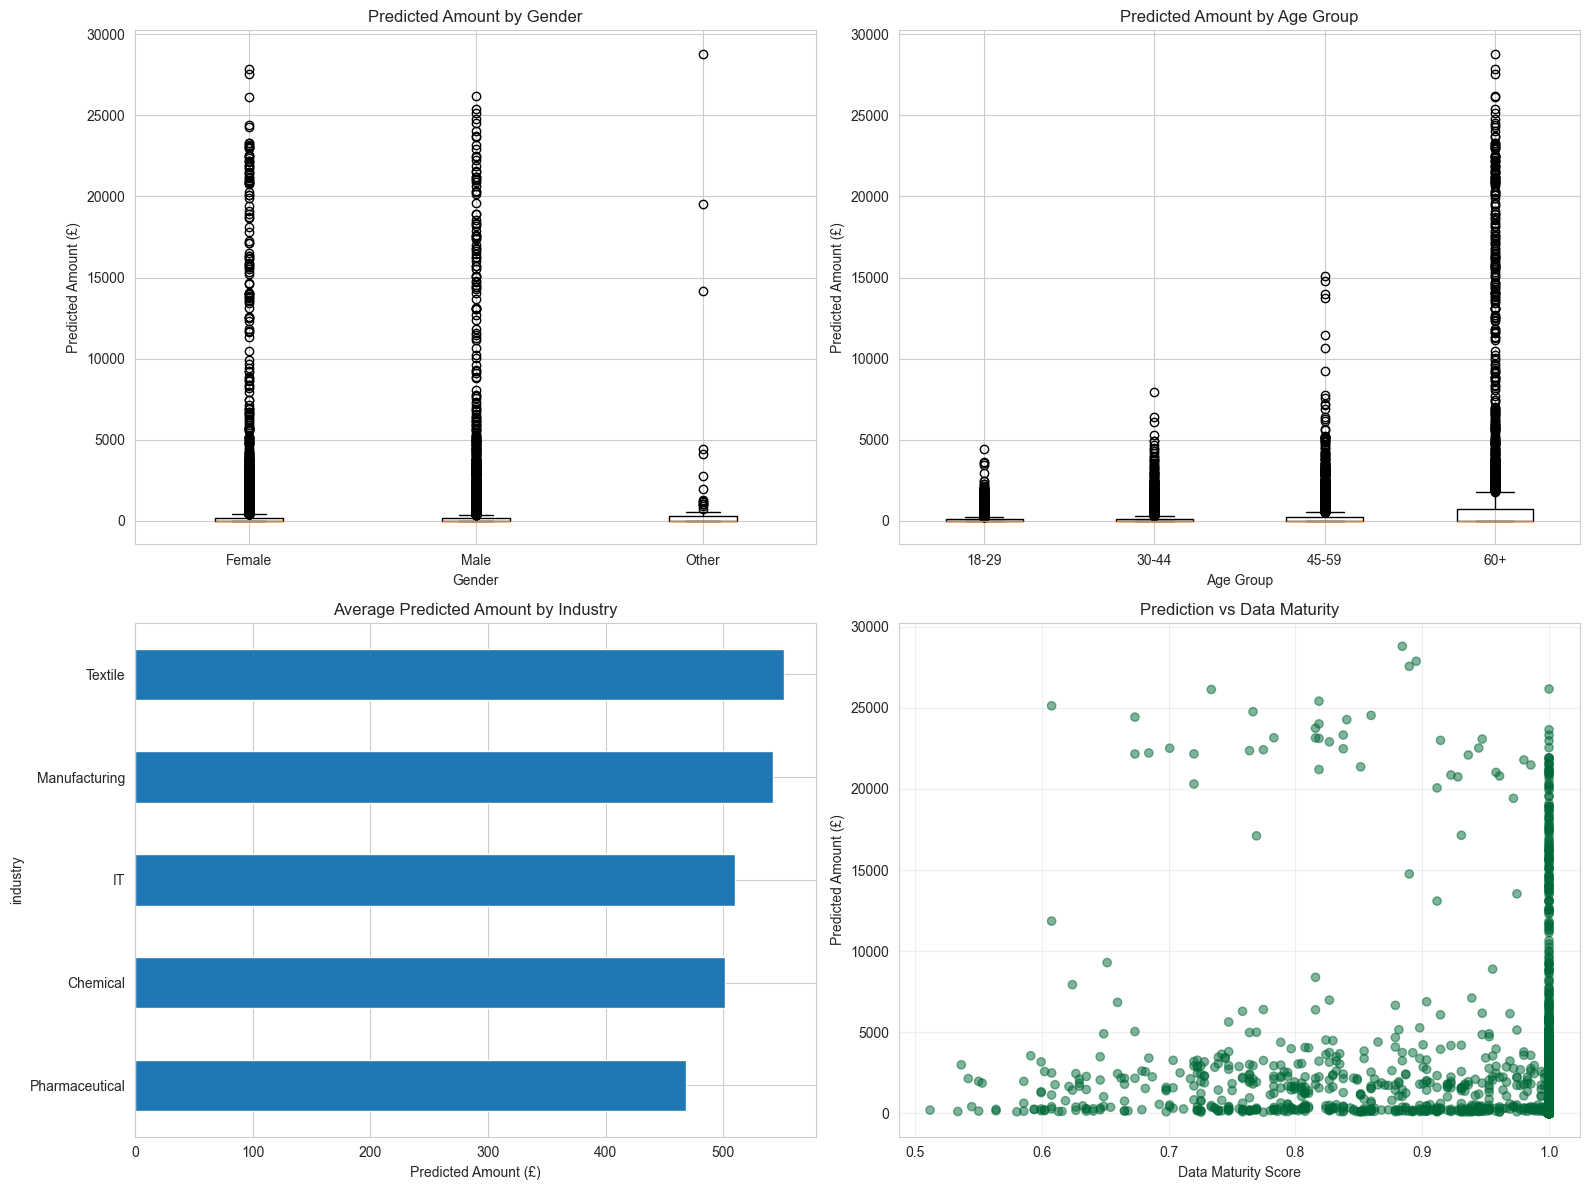

In [35]:
# ============================================================================
# 12. CATEGORICAL FEATURE ANALYSIS
# ============================================================================

def analyze_categorical_impact(claims_memebr_df, predictions, features_df):
    """Analyze impact of high-cardinality categoricals"""
    
    print(f"\n{'='*60}")
    print(f"CATEGORICAL FEATURE IMPACT ANALYSIS")
    print(f"{'='*60}")
    
    # Merge predictions with original features (not encoded)
    analysis_df = features_df.merge(predictions, on='Unique ID')
    
    # Analyze by condition category
    print("\nPredictions by Primary Condition Category:")
    if 'primary_condition_category' in analysis_df.columns:
        condition_analysis = analysis_df.groupby('primary_condition_category').agg({
            'predicted_claim_count': ['mean', 'std', 'count'],
            'predicted_claim_amount': ['mean', 'std']
        }).round(2)
        print(condition_analysis)
    
    # Analyze by gender (including 3 categories)
    print("\nPredictions by Gender:")
    if 'gender' in analysis_df.columns:
        gender_analysis = analysis_df.groupby('gender').agg({
            'predicted_claim_count': ['mean', 'std', 'count'],
            'predicted_claim_amount': ['mean', 'std']
        }).round(2)
        print(gender_analysis)
    
    # Analyze by industry
    print("\nPredictions by Industry:")
    if 'industry' in analysis_df.columns:
        industry_analysis = analysis_df.groupby('industry').agg({
            'predicted_claim_count': ['mean', 'std', 'count'],
            'predicted_claim_amount': ['mean', 'std']
        }).round(2)
        print(industry_analysis)
    
    # Analyze by age group
    print("\nPredictions by Age Group:")
    if 'age_group' in analysis_df.columns:
        age_analysis = analysis_df.groupby('age_group').agg({
            'predicted_claim_count': ['mean', 'std', 'count'],
            'predicted_claim_amount': ['mean', 'std']
        }).round(2)
        print(age_analysis)
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gender
    if 'gender' in analysis_df.columns:
        gender_data = [analysis_df[analysis_df['gender'] == g]['predicted_claim_amount'].values 
                      for g in analysis_df['gender'].unique() if len(analysis_df[analysis_df['gender'] == g]) > 0]
        if len(gender_data) > 0:
            axes[0, 0].boxplot(gender_data, labels=analysis_df['gender'].unique())
            axes[0, 0].set_title('Predicted Amount by Gender')
            axes[0, 0].set_xlabel('Gender')
            axes[0, 0].set_ylabel('Predicted Amount (£)')
    
    # Age group
    if 'age_group' in analysis_df.columns:
        age_groups = sorted(analysis_df['age_group'].unique())
        age_data = [analysis_df[analysis_df['age_group'] == ag]['predicted_claim_amount'].values 
                   for ag in age_groups if len(analysis_df[analysis_df['age_group'] == ag]) > 0]
        if len(age_data) > 0:
            axes[0, 1].boxplot(age_data, labels=age_groups)
            axes[0, 1].set_title('Predicted Amount by Age Group')
            axes[0, 1].set_xlabel('Age Group')
            axes[0, 1].set_ylabel('Predicted Amount (£)')
    
    # Industry
    if 'industry' in analysis_df.columns:
        industry_means = analysis_df.groupby('industry')['predicted_claim_amount'].mean().sort_values()
        if len(industry_means) > 0:
            industry_means.plot(kind='barh', ax=axes[1, 0])
            axes[1, 0].set_title('Average Predicted Amount by Industry')
            axes[1, 0].set_xlabel('Predicted Amount (£)')
        # Data maturity impact
    if 'data_maturity_score' in predictions.columns:
        axes[1, 1].scatter(predictions['data_maturity_score'], 
                          predictions['predicted_claim_amount'],
                          alpha=0.5, c=predictions['is_new_member'], cmap='RdYlGn_r')
        axes[1, 1].set_title('Prediction vs Data Maturity')
        axes[1, 1].set_xlabel('Data Maturity Score')
        axes[1, 1].set_ylabel('Predicted Amount (£)')
        axes[1, 1].grid(True, alpha=0.3)
    

    plt.tight_layout()
    plt.show()
    return analysis_df
analysis_df = analyze_categorical_impact(claims_memebr_df, predictions, features_df)

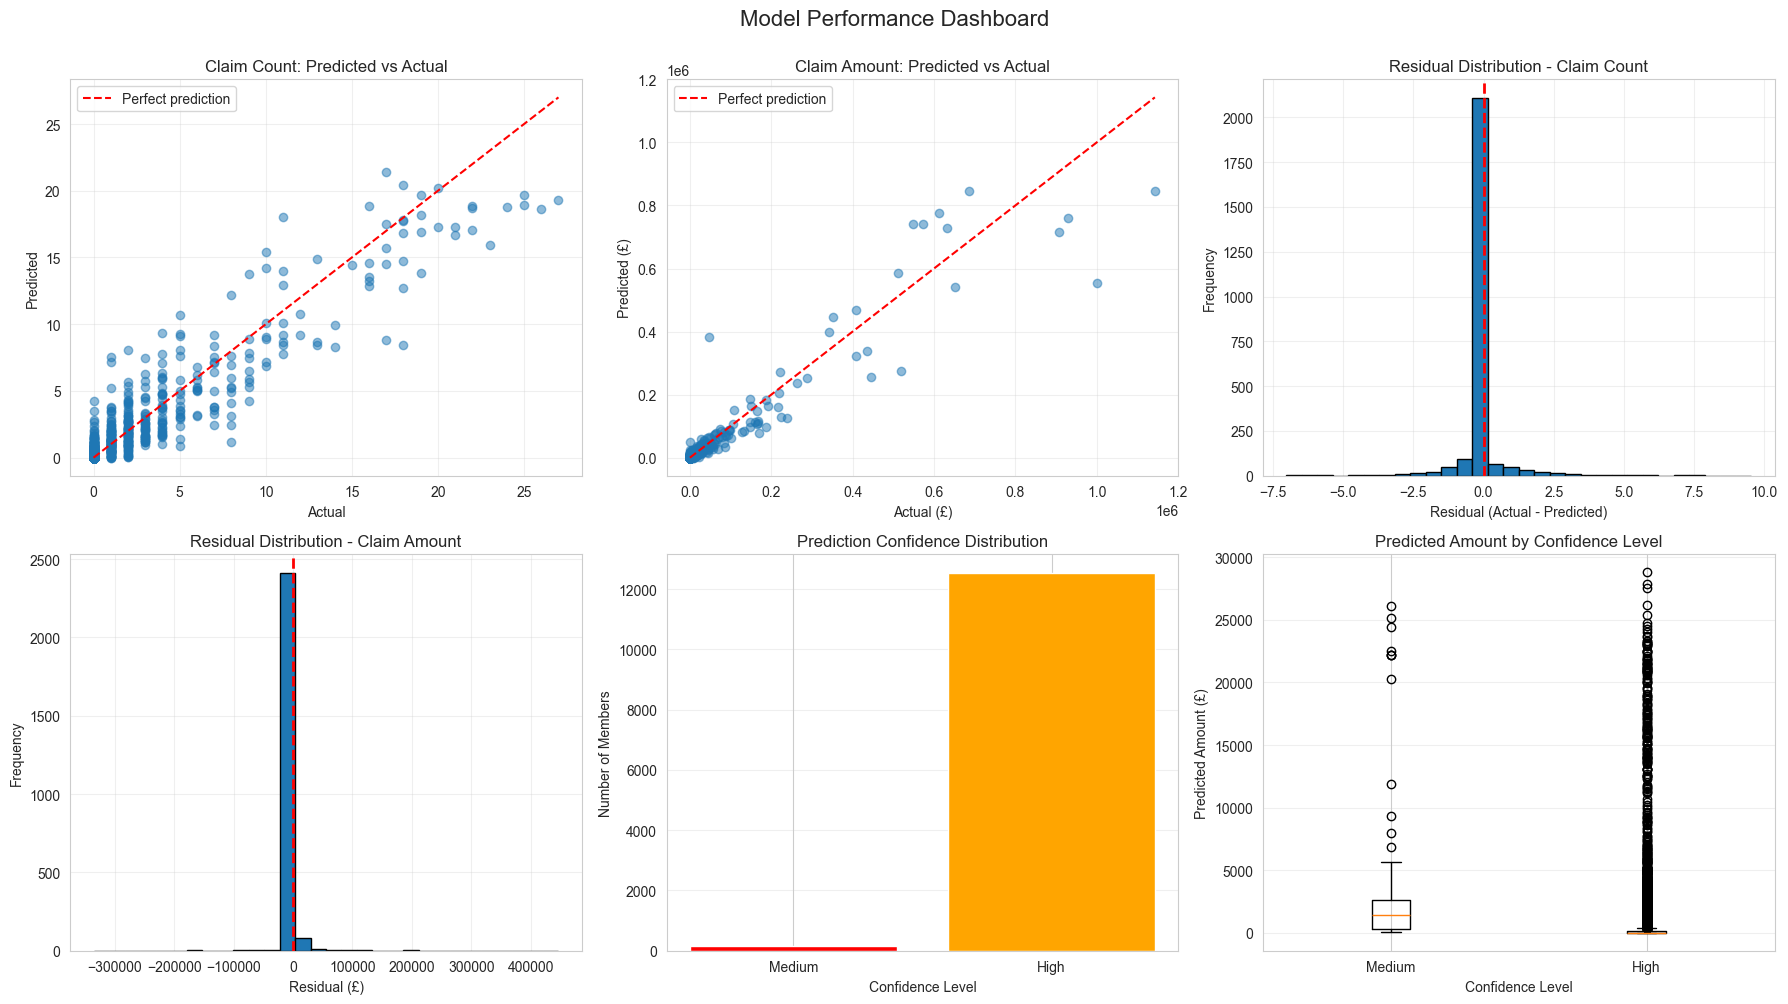

In [21]:
# ============================================================================
# 13. MODEL PERFORMANCE VISUALIZATION
# ============================================================================

def visualize_model_performance(results_count, results_amount, predictions):
    """Comprehensive performance visualization"""
    
    # Extract best model results
    best_count = results_count[min(results_count.keys(), key=lambda k: results_count[k]['mae'])]
    best_amount = results_amount[min(results_amount.keys(), key=lambda k: results_amount[k]['mae'])]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Performance Dashboard', fontsize=16, y=1.00)
    
    # 1. Predicted vs Actual - Count
    ax = axes[0, 0]
    ax.scatter(best_count['actuals'], best_count['predictions'], alpha=0.5)
    max_val = max(best_count['actuals'].max(), best_count['predictions'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')
    ax.set_title('Claim Count: Predicted vs Actual')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Predicted vs Actual - Amount
    ax = axes[0, 1]
    ax.scatter(best_amount['actuals'], best_amount['predictions'], alpha=0.5)
    max_val = max(best_amount['actuals'].max(), best_amount['predictions'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')
    ax.set_title('Claim Amount: Predicted vs Actual')
    ax.set_xlabel('Actual (£)')
    ax.set_ylabel('Predicted (£)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Residuals - Count
    ax = axes[0, 2]
    residuals = best_count['actuals'] - best_count['predictions']
    ax.hist(residuals, bins=30, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_title('Residual Distribution - Claim Count')
    ax.set_xlabel('Residual (Actual - Predicted)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # 4. Residuals - Amount
    ax = axes[1, 0]
    residuals = best_amount['actuals'] - best_amount['predictions']
    ax.hist(residuals, bins=30, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2)
    ax.set_title('Residual Distribution - Claim Amount')
    ax.set_xlabel('Residual (£)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # 5. Confidence level distribution
    ax = axes[1, 1]
    confidence_counts = predictions['confidence_level'].value_counts()
    confidence_order = ['Low', 'Medium', 'High']
    # Reorder to Low, Medium, High
    confidence_counts = confidence_counts.reindex([c for c in confidence_order if c in confidence_counts.index])
    colors = ['red', 'orange', 'green'][:len(confidence_counts)]
    ax.bar(range(len(confidence_counts)), confidence_counts.values, color=colors)
    ax.set_xticks(range(len(confidence_counts)))
    ax.set_xticklabels(confidence_counts.index)
    ax.set_title('Prediction Confidence Distribution')
    ax.set_xlabel('Confidence Level')
    ax.set_ylabel('Number of Members')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 6. Prediction amount by confidence
    ax = axes[1, 2]
    confidence_order = ['Low', 'Medium', 'High']
    conf_data = [predictions[predictions['confidence_level'] == c]['predicted_claim_amount'].values 
                 for c in confidence_order if c in predictions['confidence_level'].unique()]
    conf_labels = [c for c in confidence_order if c in predictions['confidence_level'].unique()]
    
    if len(conf_data) > 0:
        bp = ax.boxplot(conf_data, labels=conf_labels)
        ax.set_title('Predicted Amount by Confidence Level')
        ax.set_xlabel('Confidence Level')
        ax.set_ylabel('Predicted Amount (£)')
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

visualize_model_performance(results_count, results_amount, predictions)

In [23]:
# ============================================================================
# 14. FINAL SUMMARY AND EXPORT
# ============================================================================

# Extract best model results
best_count_name = min(results_count.keys(), key=lambda k: results_count[k]['mae'])
best_amount_name = min(results_amount.keys(), key=lambda k: results_amount[k]['mae'])
best_count_results = results_count[best_count_name]
best_amount_results = results_amount[best_amount_name]

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

print(f"\n Dataset Statistics:")
print(f"  Total members: {len(features_df)}")
print(f"  Total features: {len(feature_cols)}")
print(f"  ICD codes processed: {claims_memebr_df['Condition Code'].nunique()}")
print(f"  Impairment codes processed: {claims_memebr_df['Impairment Code'].nunique()}")

print(f"\n Model Performance (Test Set):")
print(f"  Claim Count ({best_count_name}):")
print(f"    - MAE: {best_count_results['mae']:.4f}")
print(f"    - RMSE: {best_count_results['rmse']:.4f}")
print(f"    - R²: {best_count_results['r2']:.4f}")
print(f"  Claim Amount ({best_amount_name}):")
print(f"    - MAE: £{best_amount_results['mae']:,.2f}")
print(f"    - RMSE: £{best_amount_results['rmse']:,.2f}")
print(f"    - R²: {best_amount_results['r2']:.4f}")

print(f"\n Top 5 Features for Claim Count:")
if fi_count is not None:
    for idx, row in fi_count.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\n Top 5 Features for Claim Amount:")
if fi_amount is not None:
    for idx, row in fi_amount.head(5).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\n Prediction Summary:")
print(f"  Total predicted claims: {predictions['predicted_claim_count'].sum():.0f}")
print(f"  Total predicted amount: £{predictions['predicted_claim_amount'].sum():,.2f}")
print(f"  Average per member: £{predictions['predicted_claim_amount'].mean():,.2f}")

print(f"\n Key Features of This Model:")
print(f"  ✓ Handles 35,000+ ICD codes using:")
print(f"    - Frequency encoding")
print(f"    - Hierarchical encoding (chapter/category)")
print(f"    - Target encoding with smoothing")
print(f"    - Top-N grouping")
print(f"  ✓ Supports 3 gender categories")
print(f"  ✓ Handles new members (partial information)")
print(f"  ✓ Flexible prediction periods (yearly/half-yearly/quarterly)")
print(f"  ✓ Confidence scoring based on data maturity")
print(f"  ✓ 100+ engineered features")

print(f"\n Next Steps:")
print(f"  1. Export predictions: predictions.to_csv('pmi_predictions.csv')")
print(f"  2. Save models:")
print(f"     import joblib")
print(f"     joblib.dump(model_count, 'model_count.pkl')")
print(f"     joblib.dump(model_amount, 'model_amount.pkl')")
print(f"     joblib.dump(scaler_count, 'scaler_count.pkl')")
print(f"     joblib.dump(scaler_amount, 'scaler_amount.pkl')")
print(f"  3. Save encoders:")
print(f"     joblib.dump(label_encoders, 'label_encoders.pkl')")
print(f"     joblib.dump(encoding_info, 'encoding_info.pkl')")
print(f"  4. Monitor performance over time")
print(f"  5. Retrain quarterly with new data")
print(f"  6. Analyze prediction errors for model improvement")

print(f"\n✓ Notebook execution complete!")
print("="*60)


FINAL MODEL SUMMARY

 Dataset Statistics:
  Total members: 12678
  Total features: 181
  ICD codes processed: 79
  Impairment codes processed: 11315

 Model Performance (Test Set):
  Claim Count (Random Forest):
    - MAE: 0.2990
    - RMSE: 0.9156
    - R²: 0.8894
  Claim Amount (Random Forest):
    - MAE: £2,666.04
    - RMSE: £18,221.94
    - R²: 0.9028

 Top 5 Features for Claim Count:
  claims_last_180d: 0.5434
  most_common_impairment_target_encoded: 0.2222
  claims_last_90d: 0.0299
  claims_per_year: 0.0225
  years_since_contract_start: 0.0166

 Top 5 Features for Claim Amount:
  most_common_impairment_target_encoded: 0.5503
  amount_last_180d: 0.2238
  amount_last_90d: 0.1213
  claims_last_180d: 0.0094
  claims_last_90d: 0.0078

 Prediction Summary:
  Total predicted claims: 1508
  Total predicted amount: £6,437,129.84
  Average per member: £507.74

 Key Features of This Model:
  ✓ Handles 35,000+ ICD codes using:
    - Frequency encoding
    - Hierarchical encoding (chapter/c